In [1]:
import gymnasium as gym
import ale_py
import matplotlib.pyplot as plt
import torch
import time
import numpy as np
from collections import deque

from agents.a2c import A2C, update_network
from envs.ale_utils import setup_training_dir, load_checkpoint, save_checkpoint, preprocess_frame, get_state, generate_video

In [2]:
env = gym.make("ALE/Breakout-v5")
print(env.observation_space)
print(env.action_space)

Box(0, 255, (210, 160, 3), uint8)
Discrete(4)


Timesteps per episode with random behaviour : around 200  
Training timesteps (DQN paper) : 50M  
-> 250k episodes ?

In [10]:
batch_size = 16
frame_stack = 4
max_episodes = 4300
gamma = .99
lr = 5e-4
c_actor = .5
c_entropy = .01
checkpoint_frequency = 50

In [4]:
resume_training = True
version = "v2"
checkpoint = f"training/a2c/{version}/training1/4250.pth"
training_number = setup_training_dir(resume_training, "a2c", version)

max_training_time = 2 #h

In [5]:
model = A2C(input_channels=frame_stack, n_actions=4)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
ev_states = torch.load("ev_states/breakout_ev_states.pt")

In [6]:
if resume_training:
    training_vars = load_checkpoint(model, optimizer, checkpoint)
    returns, avg_values, episode_start = training_vars
else:
    episode_start = 0
    returns = []
    avg_values = []

In [ ]:
start_time = time.time()
for episode in range(episode_start, max_episodes):

    timesteps = 0
    done = False
    ep_return = 0
    last_frames = deque(maxlen=frame_stack)
    logits, log_probs, values, rewards, next_values, dones = [], [], [], [], [], []

    frame, _ = env.reset()
    phi_frame = preprocess_frame(frame)
    
    # Initially, fill the last_frames buffer with the first frame
    for _ in range(frame_stack):
        last_frames.append(phi_frame)

    state = get_state(last_frames)

    while not done:
        
        timesteps += 1
        actor_logits, value = model(state)
        m = torch.distributions.Categorical(logits=actor_logits)
        action = m.sample()
        log_prob = m.log_prob(action)

        frame, reward, done, truncated, info = env.step(action.item())
        phi_frame = preprocess_frame(frame)
        ep_return += reward

        last_frames.append(phi_frame) # Automatically removes the oldest frame
        next_state = get_state(last_frames)

        with torch.no_grad():
            _, next_value = model(next_state)

        logits.append(actor_logits)
        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.tensor(reward, dtype=torch.float32))
        next_values.append(next_value)
        dones.append(torch.tensor(done, dtype=torch.float32))

        state = next_state

        if len(log_probs) == batch_size or done:

            update_network(optimizer, logits, log_probs, values, rewards, next_values, dones, gamma, c_actor, c_entropy)
            logits, log_probs, values, rewards, next_values, dones = [], [], [], [], [], [] # Clear buffers

    returns.append(ep_return)

    _, values = model(torch.cat(ev_states, dim=0)) # Evaluate average value on evaluation states
    avg_values.append(values.mean().item())

    # print(f"Episode {episode+1} finished in {timesteps} timesteps. Return : {ep_return}.")
    if (episode + 1) % 50 == 0:
        print(f"{episode+1} episodes. Average return on last 50 episodes : {np.mean(returns[-50:])}")

    if (episode + 1) % checkpoint_frequency == 0:
        save_checkpoint(model, optimizer, returns, avg_values, episode, f"training/a2c/{version}/training{training_number}/{episode+1}.pth")
        generate_video(env, model, frame_stack, 1, f"training/a2c/{version}/training{training_number}/{episode+1}.mp4")  

    if time.time() - start_time > 3600 * max_training_time:
        print(f"Maximum training time of {max_training_time}h exceeded. Interrupting training after {episode} episodes.")
        break 
    

4300 episodes. Average return on last 50 episodes : 5.0


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Text(0, 0.5, 'Average Return')

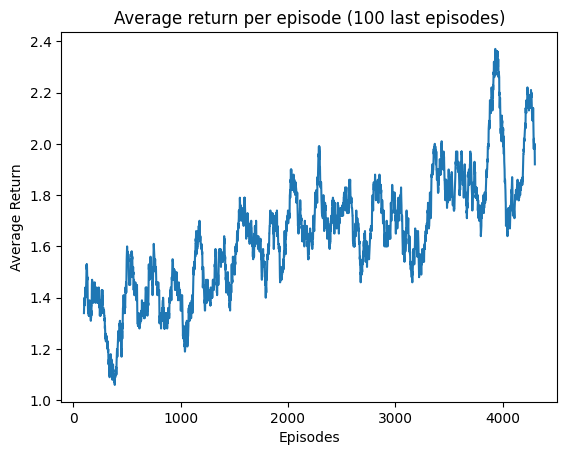

In [8]:
avg_returns = [np.mean(returns[i-100:i]) for i in range(100, len(returns))]
plt.plot(range(100, len(returns)), avg_returns)
plt.title("Average return per episode (100 last episodes)")
plt.xlabel("Episodes")
plt.ylabel("Average Return")

Text(0, 0.5, 'Average value')

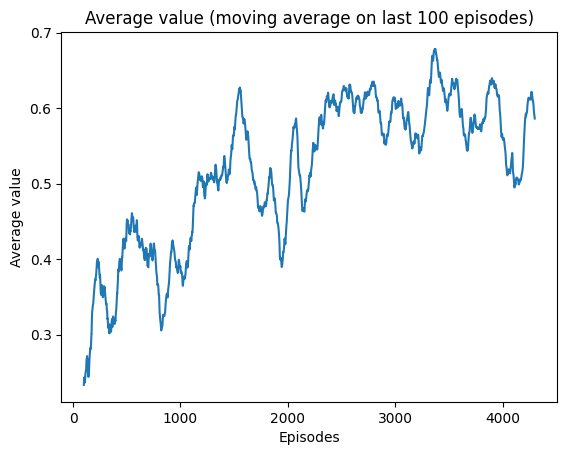

In [9]:
moving_avg_values = [np.mean(avg_values[i-100:i]) for i in range(100, len(avg_values))]
plt.plot(range(100, len(avg_values)), moving_avg_values)
plt.title("Average value (moving average on last 100 episodes)")
plt.xlabel("Episodes")
plt.ylabel("Average value")